 # Predicting User behaviour based on e-commerce data
*__Author:__ Tino Merl*

__Table of Contents__

* [Introduction and planned action](#intro)
    * [CRISP-DM](#crisp)
* [Business Understanding](#bus_und)
* [Data Understanding](#dat_und)
    * [Describing the files](#fil_descr)
    * [Describing the columns](#col_descr)
    * [Focus dataset](#fcs_data)
* [Data Preparation](#dat_pre)
    * [Plotting the data by groups](#plt_grps)
* [Modeling](#model)
* [Evaluation](#eval)

## Introduction and planned action<a class="anchor" id="intro"></a>
This is an assignment for the module applied programming in the summerterm of 2020 at the *FOM Hochschule für Oekonomie & Management* at the study center in cologne. Troughout this assignment i will work with a dataset which contains user data from an e-commerce system. The dataset can be found on kaggle named *Retailrocket recommender system dataset*.[[1](#kaggle_dataset)] The dataset contains four individual files. Since two of them (item_properties_part1 and item_properties_part2) exceed the maximum filesize allowed on github i am not able to upload them to this repository. The goal of this assignment is to predict user behaviour. This can be done in two ways. The Users can be clustered in a way to predict whether a user contains to a group that buys or not. It can also be done by using markov chains to calculate the probability of a user buying or not. This whole analysis will be done via the CRISP-DM Process. 

### CRISP-DM<a class="anchor" id="crisp"></a>
CRISP-DM stands for __C__ross __I__ndustry __S__tandard __P__rocess for __D__ata __M__ining. It is a standardized process which describes the steps a machine learning analysis and model building should undertake. The steps are the following six.

1. Business Understanding
2. Data Understanding
3. Data Preparation
4. Modeling
5. Evaluation
6. Deployment

They may be listed in a sequential manner, but there is a lot of back and forth between the steps. Especially between Business Understanding and Data Understanding, Business Understanding and Evaluation such as Data Preparation and modeling. Figure 1 illustrates the circular nature of the process.

<div style="margin:auto;">
<img style="display:block; margin-left: auto; margin-right:auto;" src="img/crisp-dm_diagramm.png"/>
<div style="width: 50%; margin:0 auto; text-align:center;"><i><b>Figure 1:</b></i> CRISP-DM diagram by statistik-dresden.de[<a href="#crisp-dm_diagramm">2</a>]</div>
</div>

Since this is an assignment the last step, the deployment, will be left out. We will therefore end the process with step number five: evaluation.

## Business Understanding<a class="anchor" id="bus_und"></a>

The first step is the business understanding. In this step the concrete goals and requirements are set before the analysis begins. The concrete tasks will also be defined here.[[2](#crisp-dm_diagramm)]
To describe it a more abstract way we want to find out whether or not a user will buy an item. This question is the main question of businesses all around the world. We have a very good datasets for this case. Clickstream data. A more precise description of the data can be found in the next chapter. We will now focus on the task of business understanding. To do so the abstract "we wan't to know a user will perform a transaction" will be broken down into several tasks. We will therefore now define the tasks for this analysis and explain them in a detailed way.

For this assignment the concrete tasks will be the following.

1. *Explorative analysis of the data in data understanding*
2. *Cluster unusual user behaviour and filter them out*
3. *How can we predict user behaviour?*

Tasks may be target of changes and additions.

The reasoning for these tasks is the following.

__1. *Explorative analysis of the data in data understanding*__

This is a really huge dataset. It contains more than 2 million rows. To even grasp what is in these files and what hidden gems may be in this dataset the data exploration must be thoroughly. Also one may argue that these part is clearly part of the data understanding chapter i wanted to make this explicit.

__2. *Cluster unusual user behaviour and filter them out*__

Filtering out the unusual user behaviour can go two ways. You could say these outliers and the unusual behaviour are exactly the users we want to take a closer look at. To catch these outliers and put them "back on the right track" may be the goal of some customer analysis. But for this task we wan't to filter them out. There are many users in the dataset who didn't buy anything or only had a very limited numbers of transactions. Therefore we have a lot of noise in the dataset. This noise could be prone to overfitting.

__3. *How can we predict user behaviour?*__

The most important question of an analysis for user behaviour is whether or not the behaviour can be predicted. This is also the whole goal of this assignment. To find out whether or not the behaviour, especially whether or not someone will buy something, can be predicted. For this case we will try to use different models and take a look at their prediction accuracy.

## Data Understanding<a class="anchor" id="dat_und"></a>

As the next step is the data understanding we should usually try to understand the data by talking with stakeholders and data owners. This is then followed by an explorative analysis of the dataset, which also creates the foundation for the following chapter the data preparation. Since this dataset has a usability score of 8.8 kaggle and has also a lot of context describing the dataset i will cite the kaggle page.[[1](#kaggle_dataset)]

### Describing the files<a class="anchor" id="fil_descr"></a>
The kaggle description seems to be a little outdated since it only speaks of three files but there are four available to download. Therefore the citation is more indirect and may differ from the original description on kaggle. As alreay mentioned the dataset consists of the following four files.

__events.csv__

A file containing the user behaviour. E.g. if a user viewed an item or added it to their cart with the corresponding item and userId and their respective timestamp.[[1](#kaggle_dataset)]

__item_properties_part1.csv and item_properties_part2.csv__

Two files containing the item properties. This refers to the property and the value of the item as their respective itemid and a timestamp. These files contain weekly snapshots of the item properties. If the property or the value of an item differs between these weekly snapshots a new row for this item will be added to the files. Since they are mostly the same files they can and will be added to one object as a union. The tricky part of this dataset is how the columns `property` and `value` refer to each other. Every value in these two columns was hashed. Except for the entries `available` and `categoryid`. When the column `property` has the entry `available` the column `value` refers to the availability of the item. Containing 1 for available and 0 for not. However if `property` contains the entry `categoryid` `value` refers to the item's category referencing the *category_tree.csv* file. All other values were stemmed and hashed. However the numeric values are marked with an n.[[1](#kaggle_dataset)] The description of the Dataset is cited as followed: 

> All words in text values were normalized (stemming procedure: https://en.wikipedia.org/wiki/Stemming) and hashed, numbers were processed as above, e.g. text "Hello world 2017!" will become "24214 44214 n2017.000"[[1](#kaggle_dataset)]

__category_tree.csv__

This files specifies a categoryId and their respective parentId.[[1](#kaggle_dataset)]

### Describing the columns<a class="anchor" id="col_descr"></a>


The following descriptions are taken from the kaggle dataset.[[1](#kaggle_dataset)]

__category_tree.csv__

* categoryid `{int}` -- unique identifier of the category.
* parentid `{int}` -- identifier of the parent category. It's empty, if parent doesn't exist.

__events.csv__

* timestamp `{int}` -- the time, when event is occurred, in milliseconds since 01-01-1970.
* visitorid `{int}` -- unique identifier of the visitor
* event `{string}` -- type of the event {“view”, “addtocart”, “transaction”}
* itemid `{int}` -- unique identifier of the item
* transactionid `{int}` -- unique identifier of the transaction (non empty only for transaction event type).

__item_properties_part1.csv__

* timestamp `{int}` -- snapshot creation time (Unix timestamp in milliseconds)
* itemid `{int}` -- unique Id of the item
* property `{str}` -- property of the Item. All of them had been hashed excluding "categoryid" and "available"
* value `{str}` -- property value of the item

__item_properties_part2.csv__

* timestamp `{int}` -- snapshot creation time (Unix timestamp in milliseconds)
* itemid `{int}` -- unique Id of the item
* property `{str}` -- property of the Item. All of them had been hashed excluding "categoryid" and "available"
* value `{str}` -- property value of the item

### Focus dataset<a class="anchor" id="fcs_data"></a>

After looking at the descriptions of the files and their respective columns it is now clear, that not all files may be relevant to our particular question. Only one file, to be precise the __events.csv__, holds the relevant information. The reasoning for this assumption is quite simple. We start with the item properties files. They are currently hashed and their column `value` contains a mixture of different values. They range from hashed text, hashed numbers, a combination of them and normal text. A change in value or pricing may lead to a user buying but since the values are all hashed it's very difficult to make a real difference in prices out in this huge set. Also to get a grasp about what is inside this dataset and whether or not it could be applied to the main question of this assignment is out of scope. Since we already banished the item properties to cancel any analysis on __category_tree.csv__ is logical. It doesn't hold any relation to the __events.csv__ and can only be used by utilizing the item properties. Therefore the now following quantitative analysis will focus solely on the __events.csv__ file. 

In [1]:
# Loading of the needed Packages
from datetime import datetime

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics

np.random.seed(28)

As the first step of the quantitave analysis we will look at the dataframe with descriptive and explorative methods. I will describe what the findings are and why they will be added to the list of the data preparations. I will try to go into more detail so there is less to write on the part of data preparation. We therefore set a fixed random seed.


In [2]:
# Loading dataset

eventsDf = pd.read_csv("./data/events.csv")
eventsDf.sample(10)

,timestamp,visitorid,event,itemid,transactionid
629976,1438573436544,895853,view,432161,NaN
348678,1434570301279,229157,view,422669,NaN
937150,1439964270842,217570,view,368947,NaN
2316508,1436751804165,1015325,view,333515,NaN
2123125,1436004758561,770911,view,321219,NaN
2218502,1436402747169,689710,view,204494,NaN
1097762,1440778593222,749691,view,298883,NaN
2275467,1436523377814,965534,view,227279,NaN
1835554,1432131850263,625059,view,343947,NaN
172391,1433905443612,672582,view,53707,NaN


By looking at our sample there are two initial findings. The first one was clear from the description of the files and their columns. `timestamp` is a unix timestamp and should be casted to a datetime object for better interpretability. But since every value, except for event, is hashed in this dataset[[1]] the timestamp cannot be converted. We will therefore specifically look at the `timestamp` to find out if any insights can be generated from it. Finding number two is that transactionid seems to be casted as a float object. This is a normal behaviour since the majority of the column looks to be empty and whenever a column contains NaN values and numerics it will be casted as float. Just to make sure this assumption is right i will look at the datatypes of `eventsDf`.

In [3]:
eventsDf.dtypes

timestamp          int64
visitorid          int64
event             object
itemid             int64
transactionid    float64
dtype: object

This reassures the assumption made above. Now we will use pandas built-in describe method to analyze the quantitative metrics for this dataset.

In [4]:
eventsDf.describe(include="all")

,timestamp,visitorid,event,itemid,transactionid
count,2.756101e+06,2.756101e+06,2756101,2.756101e+06,22457.000000
unique,NaN,NaN,3,NaN,NaN
top,NaN,NaN,view,NaN,NaN
freq,NaN,NaN,2664312,NaN,NaN
mean,1.436424e+12,7.019229e+05,NaN,2.349225e+05,8826.497796
std,3.366312e+09,4.056875e+05,NaN,1.341954e+05,5098.996290
min,1.430622e+12,0.000000e+00,NaN,3.000000e+00,0.000000
25%,1.433478e+12,3.505660e+05,NaN,1.181200e+05,4411.000000
50%,1.436453e+12,7.020600e+05,NaN,2.360670e+05,8813.000000
75%,1.439225e+12,1.053437e+06,NaN,3.507150e+05,13224.000000


Except for the already mentioned empty columns  in `transactionid` there seems to be nothing out of ordinary. None of the other columns has any indications that any cell may be empty since their counts are all on the same level. Since the `timestamp` is still in unix format and `visitorid` as `itemid` are id columns it is hard to make any assumptions based on descriptive statistics. Nevertheless it is noteworthy that the most common entry in the column `event` is view with 2664312 occurences. Since there are only two other unique values that means there are only 91789 left for the other two levels of `event`. This is noteworthy because we have a massive overrepresantation of the top value while the other two values "addtocart" and "transaction", which are the ones targeted respectively those of interest. For now we will only plot the frequency in the data. Later on the data will be plotted with the first groupings.

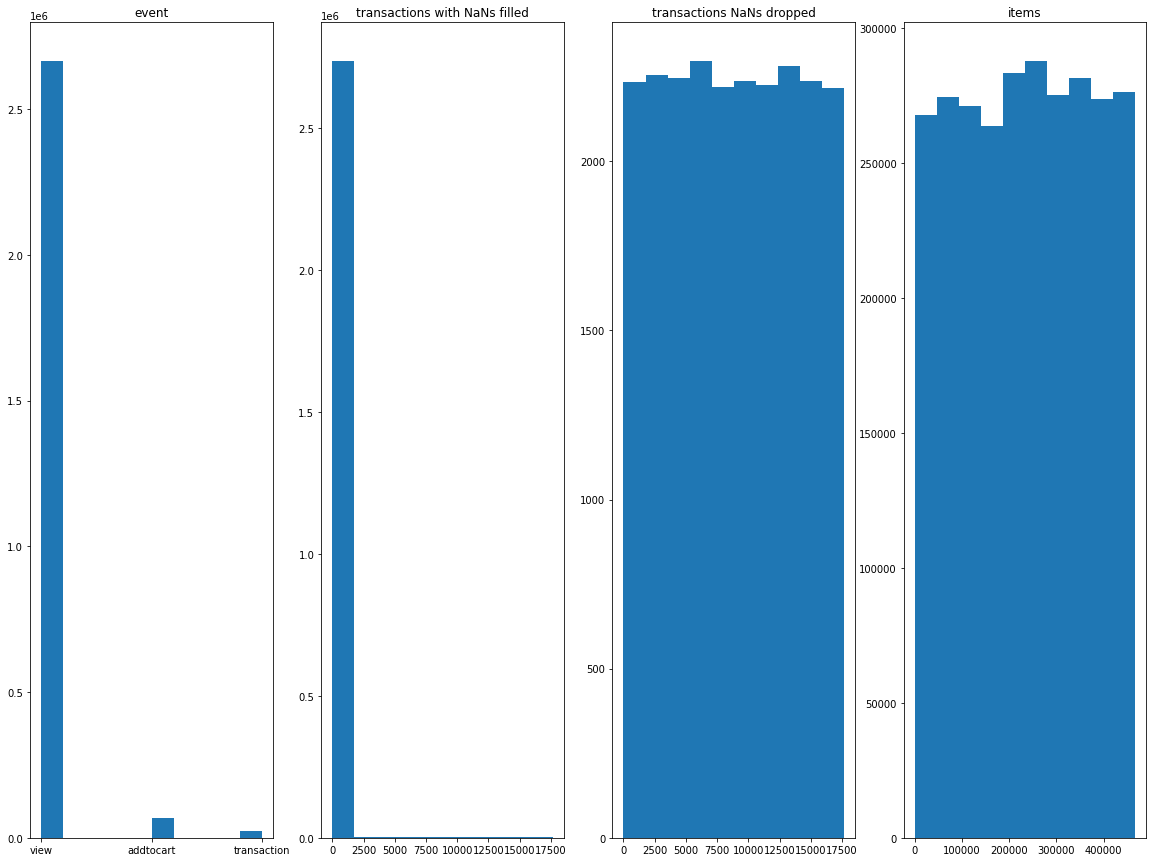

In [5]:
fig, ax = plt.subplots(ncols=4, nrows=1, figsize=(20, 15))

ax[0].hist(eventsDf["event"])
ax[0].set_title("event")
ax[1].hist(eventsDf["transactionid"].fillna(0))
ax[1].set_title("transactions with NaNs filled")
ax[2].hist(eventsDf["transactionid"].dropna())
ax[2].set_title("transactions NaNs dropped")
ax[3].hist(eventsDf["itemid"].dropna())
ax[3].set_title("items")

plt.draw()

This further concludes the assumption that most of the users don't have any transactions. To find out how many users actually bought something or not we will save them in a new variable called `buyingUsers`. The percentage of buying users will then be calculated. Therefore we will first filter out the userIds which made a transaction.

In [6]:
buyingUsers = pd.DataFrame(
    eventsDf[eventsDf.event == "transaction"]["visitorid"]
    .copy()
    .drop_duplicates(keep="first")
    .reset_index(drop=True)
)

percBuying = buyingUsers.shape[0]/eventsDf["visitorid"].unique().shape[0]

print(f"Unique number of users who made a transaction: {buyingUsers.shape[0]}")
print(f"Percentage of unique users who made a transaction: {percBuying}")

Unique number of users who made a transaction: 11719
Percentage of unique users who made a transaction: 0.00832563690873698


The number of visitors who made a transaction and bought something is 11719. This number alone doesn't say alot. But compared to the number of all visitors we will get a better outlook of how many users made a transaction. We found out that only 8.33% of the visitors made an actual transaction. That is a small number we have to lay our focus on to identify potential buyers. So we must be careful to not overfit our model. The last thing to look at now is whether or not we can generate any insights from the timestamp. A useful idea would be to calculate sessions per user. If we set a session timer to a certain treshold, let's say 30 minutes between to actions, we could group these actions by sessions. To find out if the column is of any use for this question we will randomly select a user who bought an item and look at their customer journey.

In [7]:
sampleUser = eventsDf[eventsDf["event"] == "transaction"]["visitorid"].sample(1).tolist()[0]
sampleDf = eventsDf[eventsDf["visitorid"] == sampleUser].sort_values("timestamp").reset_index(drop=True)
sampleDf

,index,timestamp,visitorid,event,itemid,transactionid
0,1505317,1430838644676,227091,view,168491,NaN
1,1505456,1430838715893,227091,view,168491,NaN
2,1505524,1430838748817,227091,view,461710,NaN
3,1520532,1430838772830,227091,view,200507,NaN
4,1505490,1430838837618,227091,view,168491,NaN
...,...,...,...,...,...,...
687,2001171,1432837930454,227091,addtocart,150173,NaN
688,1996661,1432838003880,227091,transaction,150173,15947.0
689,2006778,1432838554655,227091,view,277082,NaN
690,1991436,1432839193440,227091,view,440560,NaN


In [17]:
for i in range(20):
    startDate = sampleDf.loc[i,"timestamp"]
    endDate = sampleDf.loc[i + 1,"timestamp"]
    print(f"Time difference in hours: {(endDate - startDate)/60/60}")

Time difference in hours: 19.782500000000002
Time difference in hours: 9.145555555555555
Time difference in hours: 6.670277777777778
Time difference in hours: 17.996666666666666
Time difference in hours: 64.42027777777778
Time difference in hours: 92.63694444444444
Time difference in hours: 38.02055555555555
Time difference in hours: 78.93333333333334
Time difference in hours: 114.00916666666667
Time difference in hours: 9.633055555555556
Time difference in hours: 76.77305555555556
Time difference in hours: 63.87472222222222
Time difference in hours: 1.2794444444444444
Time difference in hours: 156.6447222222222
Time difference in hours: 7.4063888888888885
Time difference in hours: 17.86777777777778
Time difference in hours: 71.56722222222223
Time difference in hours: 61.89277777777777
Time difference in hours: 23.328611111111112
Time difference in hours: 135.45555555555555


It seems, that we cannot generate insights from the timestamp since the values were hashed in a manner, that made them unusable. This is still only evidence and not a proof. We therefore will add a column to the dataframe and look especially at the transactions and the events that lead to them.

In [22]:
sampleDf["duration"] = 0
for i in range(sampleDf.shape[0]):
    if i != 0 and i != sampleDf.shape[0] - 1:
        duration = (sampleDf.loc[i, "timestamp"] - sampleDf.loc[i-1, "timestamp"])/60/60
        sampleDf.loc[i,"duration"] = duration
        
sampleDf

,index,timestamp,visitorid,event,itemid,transactionid,duration
0,1505317,1430838644676,227091,view,168491,NaN,0.000000
1,1505456,1430838715893,227091,view,168491,NaN,19.782500
2,1505524,1430838748817,227091,view,461710,NaN,9.145556
3,1520532,1430838772830,227091,view,200507,NaN,6.670278
4,1505490,1430838837618,227091,view,168491,NaN,17.996667
...,...,...,...,...,...,...,...
687,2001171,1432837930454,227091,addtocart,150173,NaN,4.880556
688,1996661,1432838003880,227091,transaction,150173,15947.0,20.396111
689,2006778,1432838554655,227091,view,277082,NaN,152.993056
690,1991436,1432839193440,227091,view,440560,NaN,177.440278


We can already see a case were the hashing struck and made it hard to interpret the data. In row 688 the user made a transaction but it took him about 20 hours from adding the item to the cart and then actually buying it. A very unlikely case. Let's take a closer look at this transaction and the 10 last actions that led to it.

In [26]:
sampleDf[678:689]

,index,timestamp,visitorid,event,itemid,transactionid,duration
678,1993933,1432836620416,227091,view,82278,NaN,73.531667
679,2001260,1432837213101,227091,view,306045,NaN,164.634722
680,1993941,1432837484999,227091,view,157065,NaN,75.527222
681,1991579,1432837493411,227091,view,157065,NaN,2.336667
682,2001183,1432837501848,227091,view,130231,NaN,2.343611
683,1993907,1432837512267,227091,view,184284,NaN,2.894167
684,1993744,1432837833089,227091,view,150173,NaN,89.117222
685,1993972,1432837864687,227091,view,310720,NaN,8.777222
686,1996920,1432837912884,227091,view,60759,NaN,13.388056
687,2001171,1432837930454,227091,addtocart,150173,NaN,4.880556


This was the final proof that the timestamp is sadly not really usable for calculating any session related metrics.

## Data Preparation

The question we will pay attention to in this chapter is what model is suited for predicting whether or not a user is buying. Therefore we will do the following tasks.

1. Cast the column `timestamp` from UNIX timestampe to datetime object in `eventsDf`.
2. Cast `transactionid` in `eventsDf` to integer.
3. Carefully Select and engineer features.

In [9]:
# pd.to_datetime(eventsDf["timestamp"], unit="s")


In [10]:
buyingUsers["bought"] = 1

procEventsDf = pd.merge(eventsDf, buyingUsers, on="visitorid", how="left")
procEventsDf["bought"].fillna(0, inplace=True)
procEventsDf = pd.get_dummies(procEventsDf, columns=["event"], prefix="items")
procEventsDf = (
    procEventsDf[
        [
            "visitorid",
            "bought",
            "items_view",
            "items_addtocart",
            "items_transaction"
        ]
    ]
    .groupby(["visitorid", "bought"], as_index=False)
    .sum()
)
procEventsDf = procEventsDf.astype({
    "bought": "int64"
})
procEventsDf.sample(10)

,visitorid,bought,items_view,items_addtocart,items_transaction
516597,516597,0,1.0,0.0,0.0
144623,144623,0,1.0,0.0,0.0
1378512,1378512,0,6.0,0.0,0.0
776480,776480,0,2.0,0.0,0.0
107511,107511,0,1.0,0.0,0.0
447240,447240,0,1.0,0.0,0.0
953505,953505,0,1.0,0.0,0.0
742644,742644,0,1.0,0.0,0.0
655374,655374,0,1.0,0.0,0.0
385401,385401,0,2.0,0.0,0.0


What we now have is a dataframe with every visitorid, whether they bought or not, their number of items view, their number of items added to cart and their number of transactions. A problem is the time spent on site per visitor. But we can bypass this problem by first sorting the dataframe `eventsDf` by the column `visitorid` and then by `timestamp` in ascending order. The next Problem we will then have is the recurring users and their sessions. By just comparing the first and last time a user visited a site we will make false assumptions. A user with only two visits may have a very long overall time if we only compare the time of the first and last visit if they are two days away, when in reality he always left the site right away. But this problem can be solved by calculating sessions. We would need to iterate over every visit a specific visitor made and compare it to a certain threshhold e.g. 30 minutes. When the difference between two actions is greater than the defined treshhold a new session would be started. This would be computational expensive. Another thing that would happen is that users that only have one action per session would have zero session time. This however ist a problem we would have nevertheless we would calculate the time a user spends on the page

### Plotting the data by groups<a class="anchor" id="plt_grps"></a>
For this we will part the data into two groups. Users who bought an item and those who don't. 

/mnt/c/Users/tinom/OneDrive/Documents/repos/ecommerce-recommendation/.venv/lib/python3.7/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


KeyError: 'num_actions'

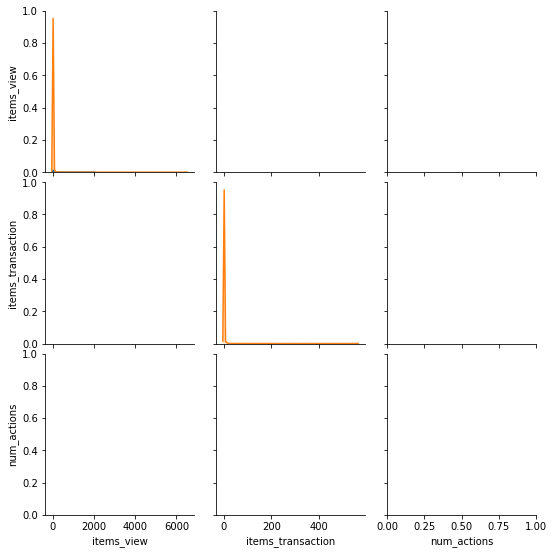

In [11]:
subset = procEventsDf.sample(frac=1)

sns.pairplot(
    subset,
    x_vars=["items_view", "items_transaction", "num_actions"],
    y_vars=["items_view", "items_transaction", "num_actions"],
    hue="bought",
)

In [ ]:
procEventsDf.drop(columns=["visitorid", "items_transaction"], inplace=True)

## Modeling

In [ ]:
procEventsDf.drop(columns=["items_addtocart"], inplace=True)

In [ ]:
X = procEventsDf[procEventsDf["num_actions"] >= 3].drop(columns=["bought"])
y = procEventsDf[procEventsDf["num_actions"] >= 3]["bought"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=28
)

ln_mod = LogisticRegression().fit(X_train, y_train)

In [ ]:
y_pred = ln_mod.predict(X_test)

metrics.accuracy_score(y_test, y_pred)

## Footnotes
[1]<a class="anchor" id="kaggle_dataset"></a> Retailrocket (2017) Retailrocket recommender system dataset, Version 4. Retrieved 2020-04-19 from https://www.kaggle.com/retailrocket/ecommerce-dataset

[2]<a class="anchor" id="crisp-dm_diagramm"></a> Wolf Riepel (2012). CRISP-DM: Ein Standard-Prozess-Modell für Data Mining. Retrieved 2020-05-10 from https://statistik-dresden.de/archives/1128